# INDEX
* [Imports and functions](#Imports-and-functions)
* [Configuration](#Configuration)
* [Prepare dataset](#Prepare-dataset)
* [Build model](#Build-model)
    * [Model inputs](#Model-inputs)
    * [Model output](#Model-output)
    * [Model](#Model)
* [Train model](#Train-model)
    * [Save model and resources](#Save-model-and-resources)
    * [Training stats](#Training-stats)
* [Test model](#Test-model)
    * [Predict with training model](#Predict-with-training-model)
    * [Predict with serving model](#Predict-with-serving-model)

# Imports and functions

In [1]:
import sys
sys.path.append('../') #append a relative path to the top package to the search path

In [2]:
import dacite
import json
import pathlib
import shutil
from typing import List

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.data.experimental import dense_to_ragged_batch
from tensorflow.keras import callbacks, layers
from tensorflow.keras.utils import plot_model
from tensorflow.python.ops import summary_ops_v2
import tensorflow_datasets as tfds

import settings

from category_classification.config import Config
from category_classification.data_utils import *
from category_classification.models import to_serving_model

from utils.io import (
    copy_category_taxonomy,
    save_category_vocabulary,
    save_config
)

# TODO
# from utils.metrics import evaluation_report


# TODO: move to lib
class TBCallback(callbacks.TensorBoard):
    """Get around a bug where you cannot use the TensorBoard callback with the StringLookup layers
    - https://github.com/tensorflow/tensorboard/issues/4530#issuecomment-783318292"""

    def _log_weights(self, epoch):
        with self._train_writer.as_default():
            with summary_ops_v2.always_record_summaries():
                for layer in self.model.layers:
                    for weight in layer.weights:
                        if hasattr(weight, "name"):
                            weight_name = weight.name.replace(":", "_")
                            summary_ops_v2.histogram(weight_name, weight, step=epoch)
                            if self.write_images:
                                self._log_weight_as_image(weight, weight_name, epoch)
                self._train_writer.flush()

2022-05-16 18:43:49.304767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 18:43:49.304787: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/gabriel/.pyenv/versions/3.8.13/envs/venv-off-tf28/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [3]:
with open('../config.json') as json_file:
    json_config = json.load(json_file)
    config = dacite.from_dict(Config, json_config)

model_config = config.model_config
train_config = config.train_config

CACHE_DIR = pathlib.Path('../cache')
CACHE_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = pathlib.Path('../models')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

PREPROC_BATCH_SIZE = 10_000  # some large value
PREDICT_BATCH_SIZE = 128

TRAIN_SPLIT = 'train'
VAL_SPLIT = 'val'
TEST_SPLIT = 'test'

# ONLY FOR DEMO PURPOSE, so training goes faster
#TRAIN_SPLIT = 'train[:10%]'
#VAL_SPLIT = 'val[:10%]'
#train_config.epochs = 2

# Prepare dataset

Run this once to fetch, build and cache the dataset.
Further runs will be no-ops, unless you force operations (see TFDS doc).

Once this is done, `tdfs.load('off_categories', ...)` to access the dataset.

In [4]:
import datasets.off_categories

builder = tfds.builder('off_categories')
builder.download_and_prepare()

# Or run via command line (if `tfds` is in the path):
# !cd ../datasets && tfds build off_categories

# Build model

In [5]:
tf.random.set_seed(42)

## Model inputs

In [6]:
# we use dicts so rerunning individual model cells is idempotent
inputs = {}
input_graphs = {}

In [7]:
ds = tfds.load('off_categories', split=TRAIN_SPLIT)

2022-05-16 18:43:50.627701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-16 18:43:50.627723: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-16 18:43:50.627750: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alba): /proc/driver/nvidia/version does not exist
2022-05-16 18:43:50.627929: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
%%time

feature_name = 'product_name'

product_name_input = tf.keras.Input(shape=(1,), dtype=tf.string, name=feature_name)

product_name_vectorizer = layers.TextVectorization(
    split = 'whitespace',
    max_tokens = model_config.product_name_max_tokens,
    output_sequence_length = model_config.product_name_max_length)

product_name_vectorizer.adapt(
    get_feature(ds, feature_name).batch(PREPROC_BATCH_SIZE))

x = product_name_vectorizer(product_name_input)

x = layers.Embedding(
    input_dim = product_name_vectorizer.vocabulary_size(),
    output_dim = model_config.product_name_embedding_size,
    mask_zero = False)(x)

product_name_graph = layers.Bidirectional(layers.LSTM(
    units = model_config.product_name_lstm_units,
    recurrent_dropout = model_config.product_name_lstm_recurrent_dropout,
    dropout = model_config.product_name_lstm_dropout))(x)

inputs[feature_name] = product_name_input
input_graphs[feature_name] = product_name_graph

# expected: 93000
print(len(product_name_vectorizer.get_vocabulary()))

93000
CPU times: user 29 s, sys: 14.1 s, total: 43.1 s
Wall time: 8 s


In [9]:
%%time

feature_name = 'ingredients_tags'

ingredients_input = tf.keras.Input(shape=(None,), dtype=tf.string, name=feature_name)

ingredients_vocab = get_vocabulary(
    flat_batch(get_feature(ds, feature_name), batch_size=PREPROC_BATCH_SIZE),
    min_freq = model_config.ingredient_min_count)

ingredients_graph = layers.StringLookup(
    vocabulary = ingredients_vocab,
    output_mode = 'multi_hot')(ingredients_input)

inputs[feature_name] = ingredients_input
input_graphs[feature_name] = ingredients_graph

# expected: 4223
print(len(ingredients_vocab))  # 4222 vs 4223 -> no b'' because no padded_batch

4222
CPU times: user 58.7 s, sys: 29.1 s, total: 1min 27s
Wall time: 14.1 s


## Model output

In [10]:
%%time

labels = 'categories_tags'

categories_vocab = get_vocabulary(
    flat_batch(get_feature(ds, labels), batch_size=PREPROC_BATCH_SIZE),
    min_freq = model_config.category_min_count)

# StringLookup(output_mode='multi_hot') mode requires num_oov_indices >= 1.
# We don't want OOVs in the categories_tags output layer, since it wouldn't make
# sense to predict OOV. So we'll drop the OOV in _transform below.
# Be careful when using StringLookup methods, some of them will return values
# based on a vocabulary with OOV (e.g. vocabulary_size()). Keep this in mind when
# mapping predictions back to the original vocabulary.
categories_multihot = layers.StringLookup(
    vocabulary = categories_vocab,
    output_mode = 'multi_hot',
    num_oov_indices = 1)  

def categories_encode(ds: tf.data.Dataset):
    @tf.function
    @tf.autograph.experimental.do_not_convert
    def _transform(x, y):
        y = categories_multihot(y)
        y = y[1:]  # drop OOV
        return (x, y)

    @tf.function
    @tf.autograph.experimental.do_not_convert
    def _not_empty(x, y):
        return tf.math.reduce_max(y, 0) > 0

    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
        .filter(_not_empty)
    )

# expected: 3969
print(len(categories_vocab))

3969
CPU times: user 57.1 s, sys: 28.8 s, total: 1min 25s
Wall time: 14.2 s


## Model

In [11]:
# ensure final order is independent of cell execution/insertion order
features = sorted(inputs.keys())

x = layers.Concatenate()([input_graphs[k] for k in features])
x = layers.Dropout(model_config.hidden_dropout)(x)
x = layers.Dense(model_config.hidden_dim)(x)
x = layers.Dropout(model_config.hidden_dropout)(x)
x = layers.Activation('relu')(x)
output = layers.Dense(len(categories_vocab), activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs[k] for k in features], outputs=[output])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=train_config.lr),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=train_config.label_smoothing),
    metrics = ['binary_accuracy', 'Precision', 'Recall']
)

In [12]:
model.summary()

# Model: "model"
# __________________________________________________________________________________________________
#  Layer (type)                   Output Shape         Param #     Connected to                     
# ==================================================================================================
#  product_name (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
#  text_vectorization (TextVector  (None, 30)          0           ['product_name[0][0]']           
#  ization)                                                                                         
                                                                                                  
#  ingredients_tags (InputLayer)  [(None, None)]       0           []                               
                                                                                                  
#  embedding (Embedding)          (None, 30, 64)       5952000     ['text_vectorization[0][0]']     
                                                                                                  
#  string_lookup_1 (StringLookup)  (None, 4223)        0           ['ingredients_tags[0][0]']       
                                                                                                  
#  bidirectional (Bidirectional)  (None, 128)          66048       ['embedding[0][0]']              
                                                                                                  
#  concatenate (Concatenate)      (None, 4351)         0           ['string_lookup_1[0][0]',        
#                                                                   'bidirectional[0][0]']          
                                                                                                  
#  dropout (Dropout)              (None, 4351)         0           ['concatenate[0][0]']            
                                                                                                  
#  dense (Dense)                  (None, 64)           278528      ['dropout[0][0]']                
                                                                                                  
#  dropout_1 (Dropout)            (None, 64)           0           ['dense[0][0]']                  
                                                                                                  
#  activation (Activation)        (None, 64)           0           ['dropout_1[0][0]']              
                                                                                                  
#  dense_1 (Dense)                (None, 3969)         257985      ['activation[0][0]']             
                                                                                                  
# ==================================================================================================
# Total params: 6,554,561
# Trainable params: 6,554,561
# Non-trainable params: 0

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product_name (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 30)          0           ['product_name[0][0]']           
 ization)                                                                                         
                                                                                                  
 ingredients_tags (InputLayer)  [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       5952000     ['text_vectorization[0][0]'] 

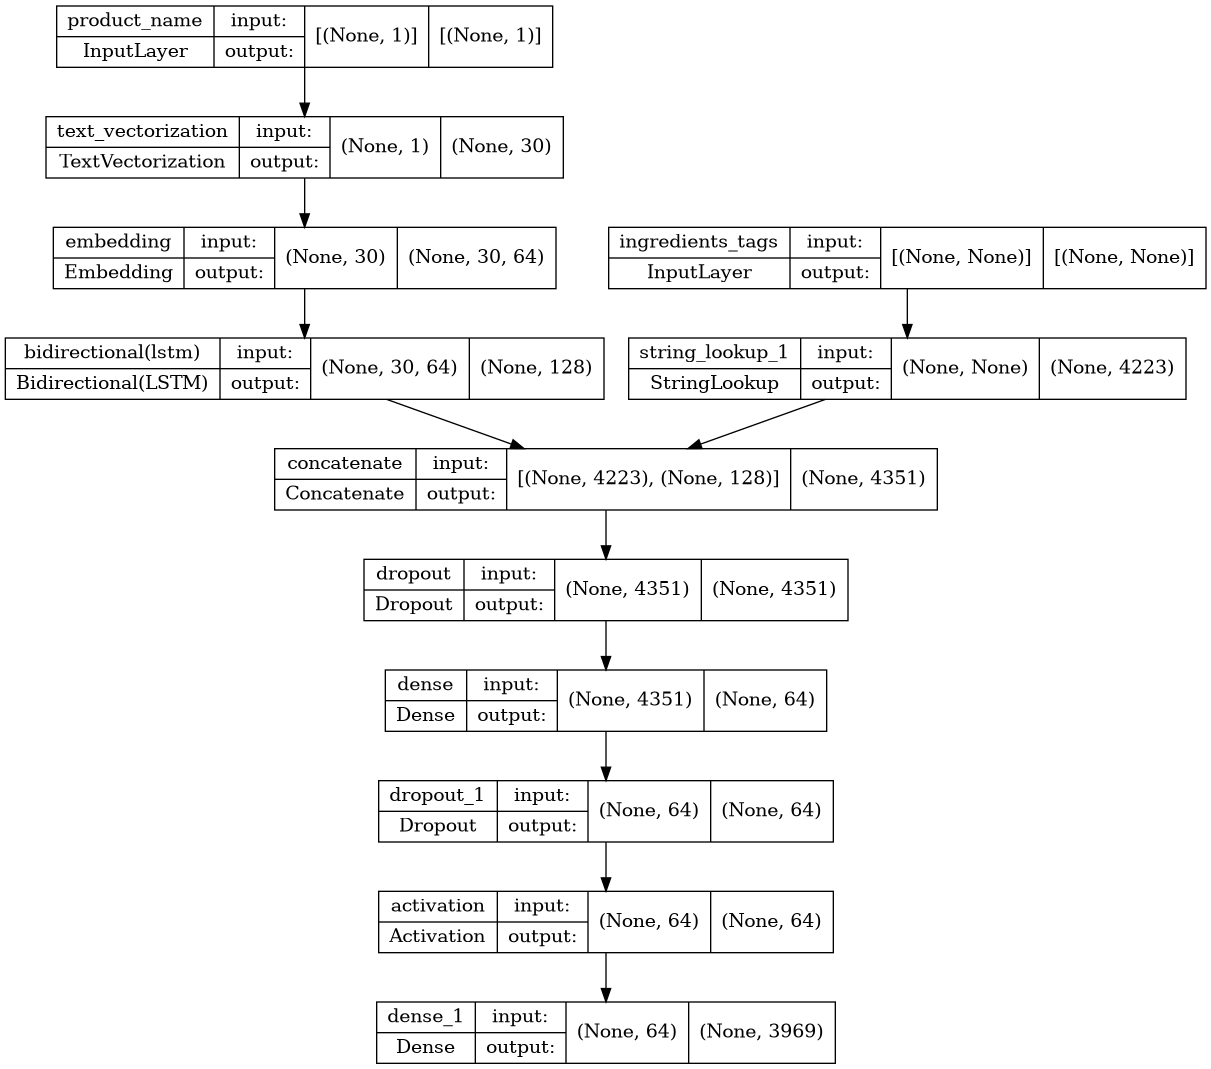

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Train model

In [14]:
%%time

# for now, clear cache on each call to fit(), to be safe
shutil.rmtree(CACHE_DIR, ignore_errors=True)
CACHE_DIR.mkdir()

# FIXME: clean OUTPUT_DIR?

print(f"Cache directory: {CACHE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

# FIXME: drop unused features (cause slower training?)

ds_train = (
    tfds.load('off_categories', split=TRAIN_SPLIT, as_supervised=True)
    .apply(categories_encode)
    .apply(dense_to_ragged_batch(train_config.batch_size))
    .cache(str(CACHE_DIR / 'train'))
)

ds_val = (
    tfds.load('off_categories', split=VAL_SPLIT, as_supervised=True)
    .apply(categories_encode)
    .apply(dense_to_ragged_batch(train_config.batch_size))
    .cache(str(CACHE_DIR / 'val'))
)

history = model.fit(
    ds_train,
    epochs = train_config.epochs,
    validation_data = ds_val,
    callbacks = [
        callbacks.TerminateOnNaN(),
        callbacks.ModelCheckpoint(
            filepath = str(OUTPUT_DIR / "weights.{epoch:02d}-{val_loss:.4f}"),
            monitor = 'val_loss',
            save_best_only = True,
            save_format = 'tf',
        ),
        callbacks.EarlyStopping(monitor='val_loss', patience=4),
        callbacks.CSVLogger(str(OUTPUT_DIR / 'training.log')),
        callbacks.History()
    ]
)

# Epoch 1/50
# 5465/5465 [==============================] - 451s 82ms/step - loss: 0.0082 - binary_accuracy: 0.9985 - precision: 0.2248 - recall: 0.0864 - val_loss: 0.0041 - val_binary_accuracy: 0.9990 - val_precision: 0.8444 - val_recall: 0.2421
# Epoch 18/50
# 5465/5465 [==============================] - 390s 71ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8880 - recall: 0.7968 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8886 - val_recall: 0.7911
# Training ended
# CPU times: user 10h 56min 3s, sys: 49min 56s, total: 11h 45min 59s
# Wall time: 2h 3min 54s

Cache directory: ../cache
Output directory: ../models
Epoch 1/50


2022-05-17 00:05:05.159672: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/home/gabriel/.pyenv/versions/3.8.13/envs/venv-off-tf28/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['code'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


   5465/Unknown - 467s 85ms/step - loss: 0.0082 - binary_accuracy: 0.9985 - precision: 0.2367 - recall: 0.0810

2022-05-17 00:12:52.976384: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-05-17 00:13:06.482942: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-05-17 00:13:09.083539: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so con

INFO:tensorflow:Assets written to: ../models/weights.01-0.0041/assets


INFO:tensorflow:Assets written to: ../models/weights.01-0.0041/assets


5465/5465 [==============================] - 487s 89ms/step - loss: 0.0082 - binary_accuracy: 0.9985 - precision: 0.2367 - recall: 0.0810 - val_loss: 0.0041 - val_binary_accuracy: 0.9990 - val_precision: 0.8445 - val_recall: 0.2502
Epoch 2/50


2022-05-17 00:13:12.477611: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5465/5465 [==============================] - ETA: 0s - loss: 0.0033 - binary_accuracy: 0.9992 - precision: 0.8168 - recall: 0.4147INFO:tensorflow:Assets written to: ../models/weights.02-0.0023/assets


INFO:tensorflow:Assets written to: ../models/weights.02-0.0023/assets


5465/5465 [==============================] - 426s 78ms/step - loss: 0.0033 - binary_accuracy: 0.9992 - precision: 0.8168 - recall: 0.4147 - val_loss: 0.0023 - val_binary_accuracy: 0.9994 - val_precision: 0.8864 - val_recall: 0.5579
Epoch 3/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0022 - binary_accuracy: 0.9994 - precision: 0.8467 - recall: 0.5971INFO:tensorflow:Assets written to: ../models/weights.03-0.0018/assets


INFO:tensorflow:Assets written to: ../models/weights.03-0.0018/assets


5465/5465 [==============================] - 417s 76ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - precision: 0.8467 - recall: 0.5971 - val_loss: 0.0018 - val_binary_accuracy: 0.9995 - val_precision: 0.8900 - val_recall: 0.6694
Epoch 4/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8583 - recall: 0.6665INFO:tensorflow:Assets written to: ../models/weights.04-0.0016/assets


INFO:tensorflow:Assets written to: ../models/weights.04-0.0016/assets


5465/5465 [==============================] - 418s 77ms/step - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8583 - recall: 0.6665 - val_loss: 0.0016 - val_binary_accuracy: 0.9995 - val_precision: 0.8911 - val_recall: 0.7108
Epoch 5/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8653 - recall: 0.7011INFO:tensorflow:Assets written to: ../models/weights.05-0.0015/assets


INFO:tensorflow:Assets written to: ../models/weights.05-0.0015/assets


5465/5465 [==============================] - 422s 77ms/step - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8653 - recall: 0.7011 - val_loss: 0.0015 - val_binary_accuracy: 0.9996 - val_precision: 0.8904 - val_recall: 0.7360
Epoch 6/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8700 - recall: 0.7229INFO:tensorflow:Assets written to: ../models/weights.06-0.0015/assets


INFO:tensorflow:Assets written to: ../models/weights.06-0.0015/assets


5465/5465 [==============================] - 411s 75ms/step - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8700 - recall: 0.7229 - val_loss: 0.0015 - val_binary_accuracy: 0.9996 - val_precision: 0.8906 - val_recall: 0.7483
Epoch 7/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8737 - recall: 0.7381INFO:tensorflow:Assets written to: ../models/weights.07-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.07-0.0014/assets


5465/5465 [==============================] - 398s 73ms/step - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8737 - recall: 0.7381 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8896 - val_recall: 0.7597
Epoch 8/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8762 - recall: 0.7496INFO:tensorflow:Assets written to: ../models/weights.08-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.08-0.0014/assets


5465/5465 [==============================] - 390s 71ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8762 - recall: 0.7496 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8891 - val_recall: 0.7679
Epoch 9/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8786 - recall: 0.7589INFO:tensorflow:Assets written to: ../models/weights.09-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.09-0.0014/assets


5465/5465 [==============================] - 389s 71ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8786 - recall: 0.7589 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8902 - val_recall: 0.7716
Epoch 10/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9995 - precision: 0.8805 - recall: 0.7661INFO:tensorflow:Assets written to: ../models/weights.10-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.10-0.0014/assets


5465/5465 [==============================] - 390s 71ms/step - loss: 0.0013 - binary_accuracy: 0.9995 - precision: 0.8805 - recall: 0.7661 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8896 - val_recall: 0.7760
Epoch 11/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8818 - recall: 0.7720INFO:tensorflow:Assets written to: ../models/weights.11-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.11-0.0014/assets


5465/5465 [==============================] - 389s 71ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8818 - recall: 0.7720 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8903 - val_recall: 0.7790
Epoch 12/50
5464/5465 [============================>.] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7771INFO:tensorflow:Assets written to: ../models/weights.12-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.12-0.0014/assets


5465/5465 [==============================] - 389s 71ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7771 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8902 - val_recall: 0.7816
Epoch 13/50
5465/5465 [==============================] - 385s 70ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8845 - recall: 0.7813 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8899 - val_recall: 0.7842
Epoch 14/50
5465/5465 [==============================] - 386s 71ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8853 - recall: 0.7850 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.7868
Epoch 15/50
5465/5465 [==============================] - 384s 70ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8862 - recall: 0.7883 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8893 - val_recall: 0.7886
Epoch 16/50
5465/5465 [=============

## Save model and resources

In [15]:
save_config(config, OUTPUT_DIR)
copy_category_taxonomy(settings.CATEGORY_TAXONOMY_PATH, OUTPUT_DIR)
save_category_vocabulary(categories_vocab, OUTPUT_DIR)
model.save(str(OUTPUT_DIR / 'training'))
to_serving_model(model, categories_vocab).save(str(OUTPUT_DIR / "serving"))

INFO:tensorflow:Assets written to: ../models/training/assets


INFO:tensorflow:Assets written to: ../models/training/assets


INFO:tensorflow:Assets written to: ../models/serving/assets


INFO:tensorflow:Assets written to: ../models/serving/assets


## Training stats

In [16]:
log_data = pd.read_csv(OUTPUT_DIR / 'training.log')
log_data

,epoch,binary_accuracy,loss,precision,recall,val_binary_accuracy,val_loss,val_precision,val_recall
0,0,0.998548,0.008191,0.236659,0.080992,0.999008,0.004126,0.844516,0.250176
1,1,0.999159,0.003292,0.816761,0.414748,0.999360,0.002261,0.886445,0.557895
2,2,0.999386,0.002230,0.846676,0.597125,0.999484,0.001767,0.889998,0.669385
3,3,0.999471,0.001859,0.858280,0.666476,0.999531,0.001597,0.891123,0.710841
4,4,0.999498,0.001681,0.865261,0.701106,0.999559,0.001514,0.890430,0.736033
5,5,0.999512,0.001570,0.869952,0.722920,0.999572,0.001468,0.890619,0.748268
6,6,0.999523,0.001491,0.873653,0.738133,0.999584,0.001435,0.889637,0.759746
7,7,0.999532,0.001431,0.876205,0.749594,0.999591,0.001410,0.889075,0.767929
8,8,0.999541,0.001384,0.878609,0.758895,0.999598,0.001399,0.890201,0.771596
9,9,0.999548,0.001347,0.880536,0.766081,0.999601,0.001393,0.889618,0.775978


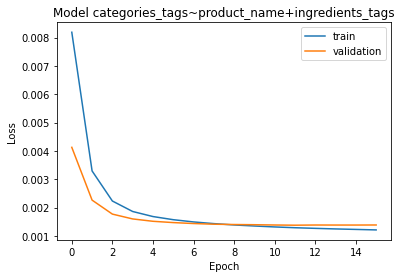

In [17]:
plt.plot(log_data['epoch'],log_data['loss'])
plt.plot(log_data['epoch'],log_data['val_loss'])
plt.title(f"Model {labels}~{'+'.join(inputs.keys())}")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

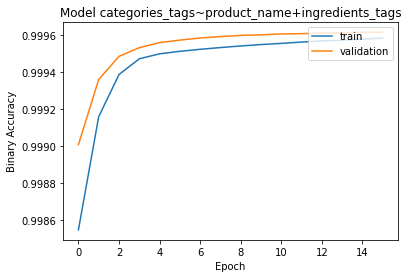

In [18]:
plt.plot(log_data['epoch'],log_data['binary_accuracy'])
plt.plot(log_data['epoch'],log_data['val_binary_accuracy'])
plt.title(f"Model {labels}~{'+'.join(inputs.keys())}")
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

# Test model

In [19]:
training_model = tf.keras.models.load_model(OUTPUT_DIR / 'training')
serving_model = tf.keras.models.load_model(OUTPUT_DIR / 'serving')

# TODO: load from saved resources
# categories_vocab = ...
# len(categories_vocab)

In [20]:
ds_test = tfds.load('off_categories', split=TEST_SPLIT)

## Predict with training model

In [21]:
%%time

training_pred_test = training_model.predict(ds_test.padded_batch(PREDICT_BATCH_SIZE))

print(training_pred_test.shape)
training_pred_test

/home/gabriel/.pyenv/versions/3.8.13/envs/venv-off-tf28/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['categories_tags', 'code'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


(87434, 3969)
CPU times: user 27.7 s, sys: 5.43 s, total: 33.2 s
Wall time: 7.08 s


array([[1.2479916e-01, 2.3162210e-01, 1.2780547e-02, ..., 5.0021164e-08,
        8.6454288e-10, 5.5262770e-08],
       [1.2578666e-03, 4.7382712e-04, 7.9527335e-06, ..., 4.8370048e-19,
        2.8506045e-15, 5.1067359e-14],
       [8.3121657e-04, 5.3051114e-04, 9.8273432e-01, ..., 9.3933331e-14,
        2.6979217e-14, 2.7250306e-11],
       ...,
       [6.1965256e-06, 1.5089888e-06, 7.3560864e-02, ..., 6.1548781e-16,
        1.3743637e-12, 6.1197694e-13],
       [2.0599736e-10, 9.2724751e-12, 1.5891012e-05, ..., 3.6298204e-14,
        8.1071217e-15, 8.1081257e-19],
       [3.8863331e-05, 1.3905764e-04, 1.7367591e-06, ..., 1.2206899e-13,
        6.5481739e-12, 3.2655463e-09]], dtype=float32)

In [22]:
# TODO: keep previous Train.ipynb manual mapping to categories to verify against serving model?

## Predict with serving model

In [23]:
%%time

# FIXME: serving_model should work with batched AND non-batched inputs (currently only batched)
serving_pred_test = serving_model.predict(ds_test.padded_batch(PREDICT_BATCH_SIZE))

serving_pred_test

CPU times: user 42.9 s, sys: 2.67 s, total: 45.6 s
Wall time: 9.97 s


[array([[5.41940868e-01, 3.30821455e-01, 2.70857453e-01, ...,
         5.75512648e-04, 5.60998917e-04, 5.54233789e-04],
        [9.96575236e-01, 9.93273735e-01, 8.53364348e-01, ...,
         2.74772560e-06, 2.30797673e-06, 2.19849267e-06],
        [9.82734323e-01, 1.89536840e-01, 1.02904856e-01, ...,
         5.08568792e-06, 4.87196257e-06, 4.83904887e-06],
        ...,
        [9.34839129e-01, 8.76605153e-01, 7.68510103e-01, ...,
         9.84208100e-07, 9.26498558e-07, 7.93223990e-07],
        [9.99778390e-01, 9.93713856e-01, 9.93560851e-01, ...,
         1.13438691e-05, 1.12647931e-05, 1.11375257e-05],
        [9.92232680e-01, 9.90504146e-01, 9.86238599e-01, ...,
         1.25050545e-04, 1.17887794e-04, 1.10795510e-04]], dtype=float32),
 array([[b'en:sausages', b'en:meats', b'en:meals', ..., b'en:cut',
         b'en:pork-meals', b'en:groceries'],
        [b'en:sauces', b'en:groceries', b'en:dips', ...,
         b'en:culinary-plants', b'en:mayonnaises',
         b'fr:condiments-a-tar

In [24]:
%%time

N_PRED_CATEGORIES = 4

top_conf = pd.DataFrame(serving_pred_test[0]).iloc[:,:N_PRED_CATEGORIES].stack()
top_cat = pd.DataFrame(serving_pred_test[1]).iloc[:,:N_PRED_CATEGORIES].stack()

top_pred = (
    pd.DataFrame.from_dict({
        'category': top_cat.apply(lambda x: x.decode()),
        'confidence': (top_conf * 100).round(2).astype(str) + '%'
    })
    .agg(lambda x: f"{x['category']}: {x['confidence']}", axis=1)
    .unstack()
)


item = (
    tfds.as_dataframe(get_features(ds_test, ['code', 'product_name']))
    .applymap(lambda x: x.decode())
)

df_test_pred = pd.concat([item, top_pred], axis=1)

del top_pred
del item

df_test_pred

CPU times: user 23.7 s, sys: 3.42 s, total: 27.1 s
Wall time: 17.1 s


,code,product_name,0,1,2,3
0,4014972150218,Bratwurst im Naturdarm,en:sausages: 54.19%,en:meats: 33.08%,en:meals: 27.09%,en:prepared-meats: 25.39%
1,0647293004720,"Cajohns, Salsa, Hot",en:sauces: 99.66%,en:groceries: 99.33%,en:dips: 85.34%,en:hot-sauces: 1.1%
2,0028400144513,Doritos Ranch 2.125z,en:snacks: 98.27%,en:groceries: 18.95%,en:crisps: 10.29%,en:sauces: 7.17%
3,0812616020026,"Beet It, Beet Juice",en:beverages: 99.69%,en:plant-based-beverages: 96.62%,en:plant-based-foods-and-beverages: 87.33%,en:juices-and-nectars: 24.05%
4,8436583952078,Cheddar,en:fermented-milk-products: 96.42%,en:fermented-foods: 95.79%,en:cheeses: 94.03%,en:dairies: 92.51%
...,...,...,...,...,...,...
87429,3700476830619,Zen Detox,en:beverages: 97.75%,en:plant-based-beverages: 65.82%,en:plant-based-foods-and-beverages: 52.8%,en:fruit-based-beverages: 17.9%
87430,3770012074012,Miel de fleurs d'été crémeux,en:bee-products: 99.93%,en:sweeteners: 99.87%,en:sweet-spreads: 99.87%,en:honeys: 99.85%
87431,0075209827376,Fine Ice Creams,en:frozen-desserts: 93.48%,en:frozen-foods: 87.66%,en:desserts: 76.85%,en:snacks: 7.36%
87432,2988761008405,Véritable andouillettes de troyes,en:meats: 99.98%,fr:andouillettes-de-troyes: 99.37%,fr:andouillettes: 99.36%,en:prepared-meats: 98.99%
